# FlightOnTime: Deep Learning


In [15]:
# ==============================================================================
# 0. CONFIGURACIÓN DE GPU
# ==============================================================================

import tensorflow as tf

# Verificar GPU
gpus = tf.config.list_physical_devices('GPU')
print(f" GPUs disponibles: {len(gpus)}")

if gpus:
    try:
        # Solo memoria dinámica, SIN mixed precision
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(" GPU configurada con memoria dinámica")
        print(" Mixed Precision DESACTIVADA para estabilidad")
    except RuntimeError as e:
        print(f"Error: {e}")
else:
    print(" No hay GPU, usando CPU")

 GPUs disponibles: 1
 GPU configurada con memoria dinámica
 Mixed Precision DESACTIVADA para estabilidad


In [16]:
# ==============================================================================
# 1. SETUP Y BIBLIOTECAS
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import holidays
import joblib
import gc

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, Model
from tensorflow.keras.regularizers import l2

# Scikit-Learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.utils import class_weight

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
np.random.seed(42)
tf.random.set_seed(42)

print(f"Setup completado")
print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {len(tf.config.list_physical_devices('GPU')) > 0}")

Setup completado
TensorFlow: 2.19.0
GPU: True


In [17]:
# ==============================================================================
# 2. CARGA DE DATOS (OPTIMIZADA)
# ==============================================================================

DATASET_PATH = 'BrFlights_Enriched_v4.csv'

print("Cargando datos...")

cols_necesarias = [
    'Companhia.Aerea', 'Aeroporto.Origem', 'Aeroporto.Destino',
    'LatOrig', 'LongOrig', 'LatDest', 'LongDest',
    'Partida.Prevista', 'Partida.Real', 'Chegada.Prevista', 'Chegada.Real',
    'precipitation', 'wind_speed', 'Situacao.Voo'
]

df = pd.read_csv(
    DATASET_PATH,
    usecols=cols_necesarias,
    dtype={'precipitation': 'float32', 'wind_speed': 'float32'},
    low_memory=False
)

print(f"Datos cargados: {df.shape}")

# Limpieza
df.drop_duplicates(inplace=True)
df = df[df['Situacao.Voo'] == 'Realizado'].copy()
df.drop(columns=['Situacao.Voo'], inplace=True)

print(f"Limpieza completada: {len(df):,} registros")

Cargando datos...
Datos cargados: (2542519, 14)
Limpieza completada: 2,252,701 registros


In [18]:
# ==============================================================================
# 3. FEATURE ENGINEERING
# ==============================================================================

print("Feature Engineering...")

# Distancia Haversine
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return r * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

cols_coords = ['LatOrig', 'LongOrig', 'LatDest', 'LongDest']
for col in cols_coords:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(subset=cols_coords, inplace=True)
df['distancia_km'] = haversine_distance(
    df['LatOrig'], df['LongOrig'], df['LatDest'], df['LongDest']
).astype('float32')
df.drop(columns=cols_coords, inplace=True)

# Variables temporales y target
cols_datas = ['Partida.Prevista', 'Partida.Real', 'Chegada.Prevista', 'Chegada.Real']
for col in cols_datas:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df.dropna(subset=['Partida.Prevista', 'Partida.Real'], inplace=True)

df['delay_minutes'] = (df['Partida.Real'] - df['Partida.Prevista']).dt.total_seconds() / 60
df['duration_minutes'] = (df['Chegada.Real'] - df['Partida.Real']).dt.total_seconds() / 60

df = df[
    (df['duration_minutes'] > 0) &
    (df['delay_minutes'] > -60) &
    (df['delay_minutes'] < 1440)
].copy()

# TARGET
df['target'] = np.where(df['delay_minutes'] > 15, 1, 0).astype('int8')

# Variables climáticas
df['precipitation'] = df['precipitation'].fillna(0).astype('float32')
df['wind_speed'] = df['wind_speed'].fillna(0).astype('float32')
df['clima_imputado'] = ((df['precipitation'] == 0) & (df['wind_speed'] == 0)).astype('int8')

# Componentes temporales
df['hora'] = df['Partida.Prevista'].dt.hour.astype('int8')
df['dia_semana'] = df['Partida.Prevista'].dt.dayofweek.astype('int8')
df['mes'] = df['Partida.Prevista'].dt.month.astype('int8')

# Feriados
br_holidays = holidays.Brazil()
df['is_holiday'] = df['Partida.Prevista'].dt.date.apply(
    lambda x: 1 if x in br_holidays else 0
).astype('int8')

df.rename(columns={
    'Companhia.Aerea': 'companhia',
    'Aeroporto.Origem': 'origem',
    'Aeroporto.Destino': 'destino'
}, inplace=True)

df.drop(columns=cols_datas + ['delay_minutes', 'duration_minutes'], inplace=True)

print(f"Feature Engineering completado")
print(f"Target: {df['target'].value_counts(normalize=True).to_dict()}")
gc.collect()

Feature Engineering...
Feature Engineering completado
Target: {0: 0.8842237503306004, 1: 0.11577624966939963}


6046

In [19]:
# ==============================================================================
# 4. PREPARACIÓN PARA EMBEDDINGS
# ==============================================================================

print("Preparando datos...")

features_num = [
    'distancia_km', 'hora', 'dia_semana', 'mes',
    'is_holiday', 'precipitation', 'wind_speed', 'clima_imputado'
]

features_cat = ['companhia', 'origem', 'destino']
label_encoders = {}

for col in features_cat:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"  {col}: {len(le.classes_)} categorías")

X = df[features_cat + features_num].copy()
y = df['target'].values

del df
gc.collect()

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTrain: {X_train.shape} | Test: {X_test.shape}")
print(f"Balance train - No Delay: {(y_train==0).mean():.2%} | Delay: {(y_train==1).mean():.2%}")

# Escalar
scaler = StandardScaler()
X_train[features_num] = scaler.fit_transform(X_train[features_num])
X_test[features_num] = scaler.transform(X_test[features_num])

# Guardar
joblib.dump(scaler, 'scaler_stable.pkl')
joblib.dump(label_encoders, 'label_encoders_stable.pkl')
joblib.dump(features_num, 'features_num_stable.pkl')

print("\nDatos preparados")

Preparando datos...
  companhia: 55 categorías
  origem: 187 categorías
  destino: 187 categorías

Train: (1790681, 11) | Test: (447671, 11)
Balance train - No Delay: 88.42% | Delay: 11.58%

Datos preparados


In [20]:
# ==============================================================================
# 5. ARQUITECTURA ESTABLE CON EMBEDDINGS
# ==============================================================================

print("Construyendo modelo ESTABLE...\n")

def build_stable_model(n_companhias, n_origens, n_destinos, n_features_num):
    """
    Arquitectura ESTABLE y PROBADA:
    - 3 capas (no 4) para mejor convergencia
    - Embeddings con regularización moderada
    - BatchNorm + Dropout conservador
    """

    # Entradas
    input_cia = layers.Input(shape=(1,), name='input_companhia', dtype='int32')
    input_ori = layers.Input(shape=(1,), name='input_origem', dtype='int32')
    input_des = layers.Input(shape=(1,), name='input_destino', dtype='int32')
    input_num = layers.Input(shape=(n_features_num,), name='input_numerico', dtype='float32')

    # Embeddings (dimensiones conservadoras)
    emb_cia = layers.Embedding(
        n_companhias, 8,
        embeddings_regularizer=l2(0.0001),
        name='emb_companhia'
    )(input_cia)

    emb_ori = layers.Embedding(
        n_origens, 16,
        embeddings_regularizer=l2(0.0001),
        name='emb_origem'
    )(input_ori)

    emb_des = layers.Embedding(
        n_destinos, 16,
        embeddings_regularizer=l2(0.0001),
        name='emb_destino'
    )(input_des)

    # Flatten
    flat_cia = layers.Flatten()(emb_cia)
    flat_ori = layers.Flatten()(emb_ori)
    flat_des = layers.Flatten()(emb_des)

    # Concatenar
    concat = layers.Concatenate()([flat_cia, flat_ori, flat_des, input_num])

    # Capa 1: 128 neuronas
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(concat)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Capa 2: 64 neuronas
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Capa 3: 32 neuronas
    x = layers.Dense(32, activation='relu')(x)

    # Salida
    output = layers.Dense(1, activation='sigmoid', name='output')(x)

    model = Model(
        inputs=[input_cia, input_ori, input_des, input_num],
        outputs=output,
        name='FlightDelay_Stable'
    )

    return model

# Construir
model = build_stable_model(
    n_companhias=len(label_encoders['companhia'].classes_),
    n_origens=len(label_encoders['origem'].classes_),
    n_destinos=len(label_encoders['destino'].classes_),
    n_features_num=len(features_num)
)

model.summary()
print(f"\nParámetros: {model.count_params():,}")

Construyendo modelo ESTABLE...



Model: "FlightDelay_Stable"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_companhia     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_origem        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_destino       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_companhia       │ (None, 1, 8)      │        440 │ input_companhia[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_origem          │ (None, 1, 16)     │      2,992 │ input_origem[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_destino         │ (None, 1, 16)     │      2,992 │ input_destino[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 8)         │          0 │ emb_companhia[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 16)        │          0 │ emb_origem[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 16)        │          0 │ emb_destino[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_numerico      │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 48)        │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ flatten_4[0][0],  │
│                     │                   │            │ flatten_5[0][0],  │
│                     │                   │            │ input_numerico[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      6,272 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dense_5[0][0]   

 Total params: 23,833 (93.10 KB)

 Trainable params: 23,449 (91.60 KB)

 Non-trainable params: 384 (1.50 KB)


Parámetros: 23,833


In [21]:
# ==============================================================================
# 6. COMPILACIÓN ESTABLE (BINARY CROSSENTROPY + CLASS WEIGHTS)
# ==============================================================================

print("Compilando modelo...\n")

# Calcular class weights
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

print(f"Class weights: {class_weights}")
print(f" (Clase minoritaria tiene peso {class_weights[1]:.2f}x mayor)\n")

# Métricas
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='pr_auc', curve='PR')
]

# Optimizer con LR conservador
optimizer = keras.optimizers.Adam(
    learning_rate=0.0001,  # MÁS BAJO que antes (era 0.001)
    clipnorm=1.0
)

# Compilar
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',  # ESTÁNDAR, no Focal Loss
    metrics=METRICS
)

print("Modelo compilado")
print("Loss: Binary Crossentropy (estable)")
print("Learning Rate: 0.0001 (conservador)")
print("Class Weights: Activados")

Compilando modelo...

Class weights: {0: np.float64(0.5654676154488895), 1: np.float64(4.318681928245497)}
 (Clase minoritaria tiene peso 4.32x mayor)

Modelo compilado
Loss: Binary Crossentropy (estable)
Learning Rate: 0.0001 (conservador)
Class Weights: Activados


In [22]:
# ==============================================================================
# 7. CALLBACKS
# ==============================================================================

callbacks_list = [
    # Early Stopping: monitorea AUC
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=10,  # MÁS PACIENCIA
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),

    # Model Checkpoint
    callbacks.ModelCheckpoint(
        'best_model_stable.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),

    # Reduce LR
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # CSV Logger
    callbacks.CSVLogger('training_log_stable.csv')
]

print("Callbacks configurados")

Callbacks configurados


In [23]:
# ==============================================================================
# 8. ENTRENAMIENTO
# ==============================================================================

print("\nIniciando entrenamiento...")
print("="*70)
print("MONITOREA EL AUC:")
print("   - Si AUC > 0.70 en época 5 → Modelo aprendiendo ")
print("   - Si AUC < 0.60 en época 10 → Problema de datos ")
print("="*70)
print()

# Preparar datos
X_train_dict = {
    'input_companhia': X_train['companhia'].values,
    'input_origem': X_train['origem'].values,
    'input_destino': X_train['destino'].values,
    'input_numerico': X_train[features_num].values
}

X_test_dict = {
    'input_companhia': X_test['companhia'].values,
    'input_origem': X_test['origem'].values,
    'input_destino': X_test['destino'].values,
    'input_numerico': X_test[features_num].values
}

# Entrenar
history = model.fit(
    X_train_dict,
    y_train,
    validation_data=(X_test_dict, y_test),
    epochs=50,
    batch_size=256,
    class_weight=class_weights,  # IMPORTANTE
    callbacks=callbacks_list,
    verbose=1
)

print("\n" + "="*70)
print("Entrenamiento completado")
print(f"Épocas: {len(history.history['loss'])}")
print(f"Mejor AUC: {max(history.history['val_auc']):.4f}")
print("="*70)


Iniciando entrenamiento...
MONITOREA EL AUC:
   - Si AUC > 0.70 en época 5 → Modelo aprendiendo 
   - Si AUC < 0.60 en época 10 → Problema de datos 

Epoch 1/50
6995/6995 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5620 - auc: 0.5461 - loss: 0.7295 - pr_auc: 0.1345 - precision: 0.1311 - recall: 0.4953
Epoch 1: val_auc improved from -inf to 0.62347, saving model to best_model_stable.keras
6995/6995 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.5620 - auc: 0.5461 - loss: 0.7295 - pr_auc: 0.1345 - precision: 0.1311 - recall: 0.4953 - val_accuracy: 0.6085 - val_auc: 0.6235 - val_loss: 0.6788 - val_pr_auc: 0.1798 - val_precision: 0.1606 - val_recall: 0.5637 - learning_rate: 1.0000e-04
Epoch 2/50
6983/6995 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5987 - auc: 0.6105 - loss: 0.6876 - pr_auc: 0.1691 - precision: 0.1550 - recall: 0.5543
Epoch 2: val_auc improved from 0.62347 to 0.64328, saving model to best_model_stable.keras
6995/6995 ━━━━━━━━━━━━━━━━━━━━ 60s 9ms/step - accuracy: 0

/tmp/ipython-input-3744660505.py:50: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3744660505.py:51: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Liberation Sans.
  plt.savefig('training_stable.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


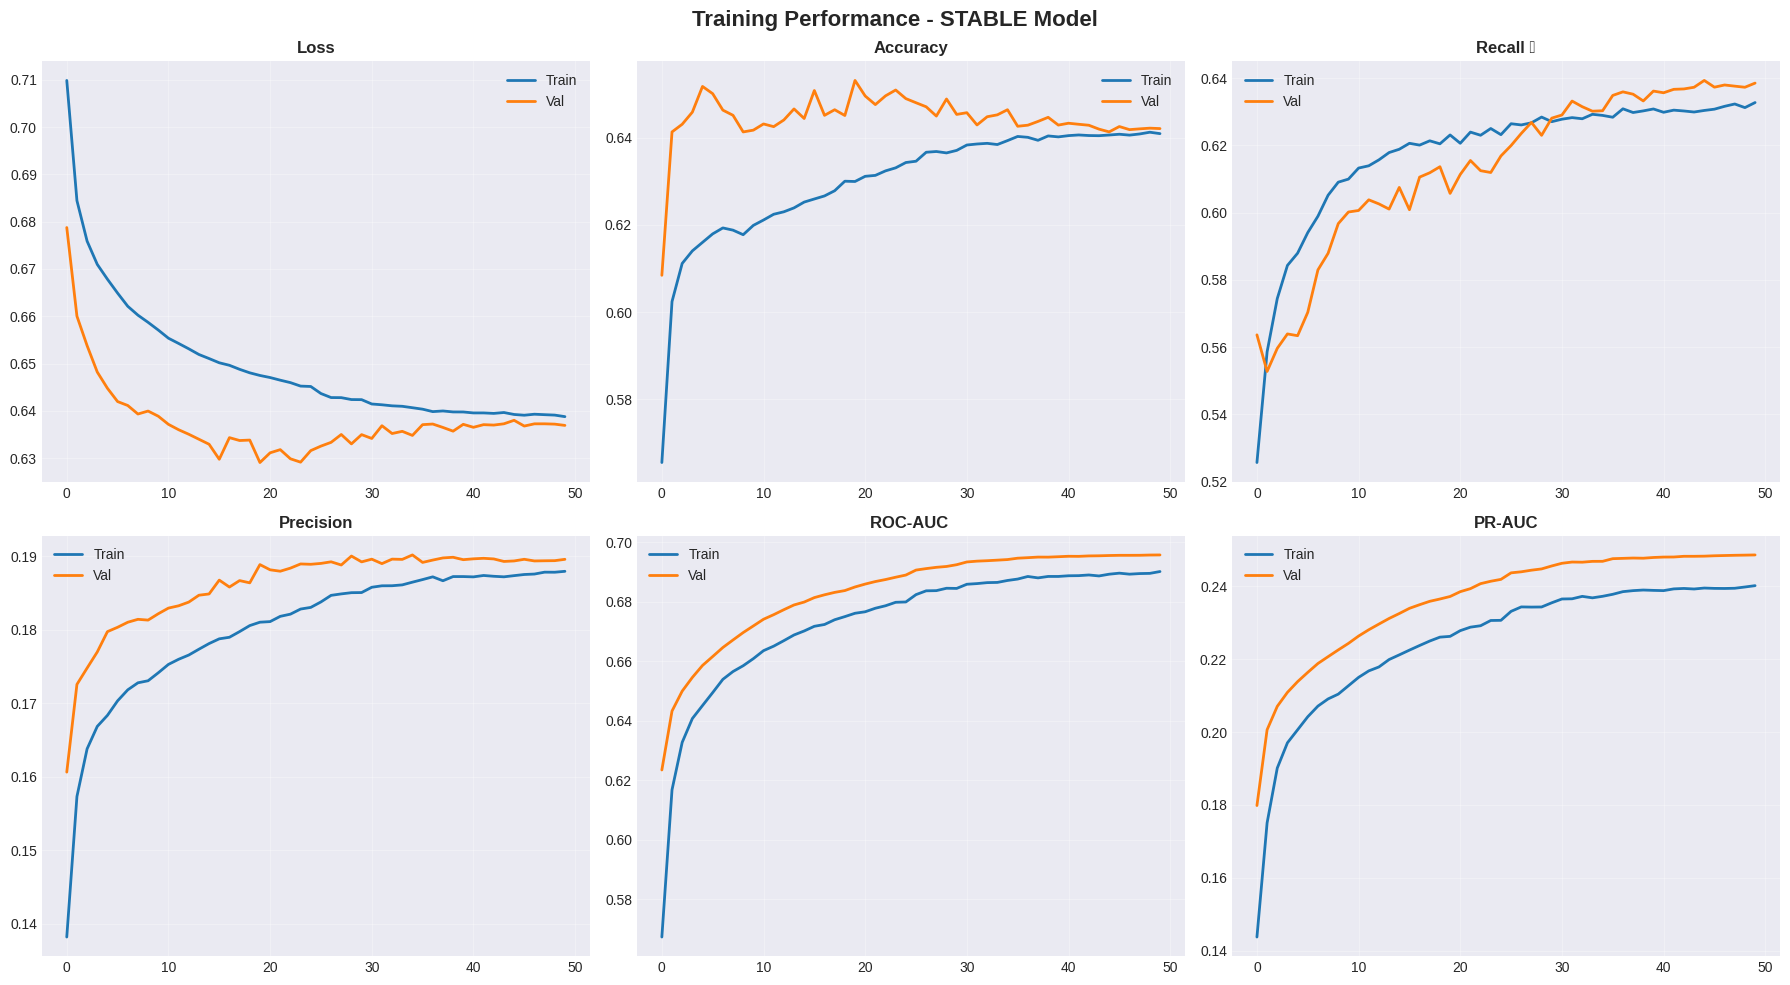

In [24]:
# ==============================================================================
# 9. VISUALIZACIÓN
# ==============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Training Performance - STABLE Model', fontsize=16, fontweight='bold')

# Loss
axes[0, 0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val', linewidth=2)
axes[0, 0].set_title('Loss', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val', linewidth=2)
axes[0, 1].set_title('Accuracy', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Recall
axes[0, 2].plot(history.history['recall'], label='Train', linewidth=2)
axes[0, 2].plot(history.history['val_recall'], label='Val', linewidth=2)
axes[0, 2].set_title('Recall ⭐', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val', linewidth=2)
axes[1, 0].set_title('Precision', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# AUC
axes[1, 1].plot(history.history['auc'], label='Train', linewidth=2)
axes[1, 1].plot(history.history['val_auc'], label='Val', linewidth=2)
axes[1, 1].set_title('ROC-AUC ', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# PR-AUC
axes[1, 2].plot(history.history['pr_auc'], label='Train', linewidth=2)
axes[1, 2].plot(history.history['val_pr_auc'], label='Val', linewidth=2)
axes[1, 2].set_title('PR-AUC', fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_stable.png', dpi=300, bbox_inches='tight')
plt.show()


 Evaluando modelo...

 MÉTRICAS FINALES (Test Set - Threshold 0.5)
Accuracy:  0.6421
Precision: 0.1896
Recall:    0.6385  (CRÍTICO)
F1-Score:  0.2923
ROC-AUC:   0.6957  (Objetivo: >0.75)

 Classification Report:

              precision    recall  f1-score   support

    No Delay       0.93      0.64      0.76    395841
       Delay       0.19      0.64      0.29     51830

    accuracy                           0.64    447671
   macro avg       0.56      0.64      0.53    447671
weighted avg       0.85      0.64      0.71    447671



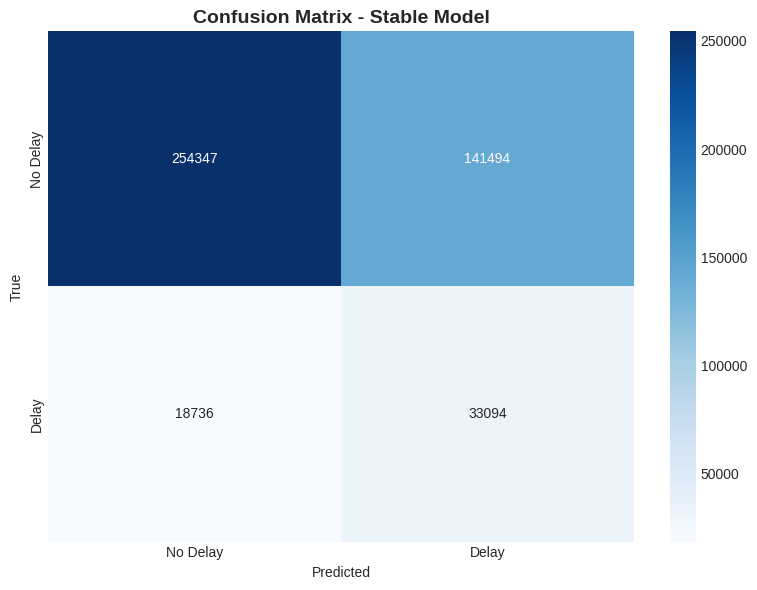


 DIAGNÓSTICO:

 AUC entre 0.60-0.70 → Modelo aprendió POCO
 Acciones:
   1. Aumentar épocas de entrenamiento
   2. Probar con más features
   3. Ajustar class_weights

 Recall > 0.50 → Buena detección de atrasos


In [25]:
# ==============================================================================
# 10. EVALUACIÓN
# ==============================================================================

print("\n Evaluando modelo...\n")

y_pred_proba = model.predict(X_test_dict, verbose=0).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("="*70)
print(" MÉTRICAS FINALES (Test Set - Threshold 0.5)")
print("="*70)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}  (CRÍTICO)")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}  (Objetivo: >0.75)")
print("="*70)

# Classification Report
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['No Delay', 'Delay']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Delay', 'Delay'],
            yticklabels=['No Delay', 'Delay'])
plt.title('Confusion Matrix - Stable Model', fontsize=14, fontweight='bold')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix_stable.png', dpi=300)
plt.show()

# Verificar si el modelo aprendió
print("\n DIAGNÓSTICO:\n")
if roc_auc < 0.60:
    print(" AUC < 0.60 → Modelo NO aprendió (apenas mejor que azar)")
    print(" Acciones:")
    print("   1. Verificar que las features tienen varianza")
    print("   2. Revisar si hay data leakage")
    print("   3. Probar con más datos de entrenamiento")
elif roc_auc < 0.70:
    print(" AUC entre 0.60-0.70 → Modelo aprendió POCO")
    print(" Acciones:")
    print("   1. Aumentar épocas de entrenamiento")
    print("   2. Probar con más features")
    print("   3. Ajustar class_weights")
elif roc_auc < 0.75:
    print(" AUC entre 0.70-0.75 → Modelo ACEPTABLE")
    print(" Ahora optimiza el threshold para maximizar Recall")
else:
    print(" AUC > 0.75 → Modelo BUENO")
    print(" ¡Procede con optimización de threshold y análisis de negocio!")

if recall < 0.30:
    print("\n Recall < 0.30 → Ajusta threshold a ~0.3 para mejorar detección")
elif recall < 0.50:
    print("\n Recall aceptable. Optimiza threshold para balance Precision/Recall")
else:
    print("\n Recall > 0.50 → Buena detección de atrasos")

 Buscando threshold óptimo...

 THRESHOLD ÓPTIMO (Máximo F2 - prioriza Recall)
Threshold: 0.425
Precision: 0.1636
Recall:    0.7811
F1-Score:  0.2705
F2-Score:  0.4451


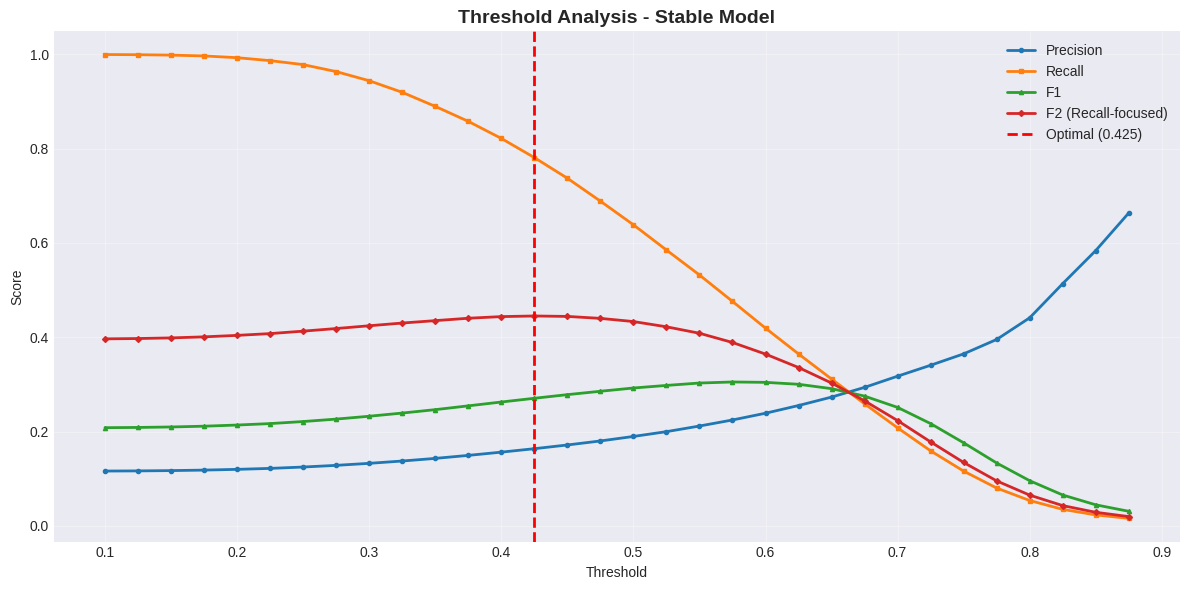


 Threshold guardado


In [26]:
# ==============================================================================
# 11. OPTIMIZACIÓN DE THRESHOLD
# ==============================================================================

print(" Buscando threshold óptimo...\n")

from sklearn.metrics import fbeta_score

thresholds = np.arange(0.1, 0.9, 0.025)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)

    results.append({
        'threshold': thresh,
        'precision': precision_score(y_test, y_pred_thresh, zero_division=0),
        'recall': recall_score(y_test, y_pred_thresh),
        'f1_score': f1_score(y_test, y_pred_thresh),
        'f2_score': fbeta_score(y_test, y_pred_thresh, beta=2)
    })

df_thresholds = pd.DataFrame(results)
best_thresh_row = df_thresholds.loc[df_thresholds['f2_score'].idxmax()]
optimal_threshold = best_thresh_row['threshold']

print("="*70)
print(" THRESHOLD ÓPTIMO (Máximo F2 - prioriza Recall)")
print("="*70)
print(f"Threshold: {optimal_threshold:.3f}")
print(f"Precision: {best_thresh_row['precision']:.4f}")
print(f"Recall:    {best_thresh_row['recall']:.4f}")
print(f"F1-Score:  {best_thresh_row['f1_score']:.4f}")
print(f"F2-Score:  {best_thresh_row['f2_score']:.4f}")
print("="*70)

# Visualizar
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_thresholds['threshold'], df_thresholds['precision'],
        label='Precision', linewidth=2, marker='o', markersize=3)
ax.plot(df_thresholds['threshold'], df_thresholds['recall'],
        label='Recall', linewidth=2, marker='s', markersize=3)
ax.plot(df_thresholds['threshold'], df_thresholds['f1_score'],
        label='F1', linewidth=2, marker='^', markersize=3)
ax.plot(df_thresholds['threshold'], df_thresholds['f2_score'],
        label='F2 (Recall-focused)', linewidth=2, marker='D', markersize=3)
ax.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2,
           label=f"Optimal ({optimal_threshold:.3f})")
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Threshold Analysis - Stable Model', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('threshold_stable.png', dpi=300)
plt.show()

# Guardar
joblib.dump(optimal_threshold, 'optimal_threshold_stable.pkl')
print("\n Threshold guardado")

In [27]:
# ==============================================================================
# 12. GUARDAR MODELO Y METADATA
# ==============================================================================

model.save('flight_delay_stable.keras')

metadata = {
    'model_version': 'stable_v1',
    'architecture': '3 layers (128-64-32)',
    'loss': 'binary_crossentropy',
    'optimizer': 'Adam(lr=0.0001)',
    'mixed_precision': False,
    'class_weights': class_weights,
    'optimal_threshold': float(optimal_threshold),
    'test_metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'roc_auc': float(roc_auc)
    },
    'test_metrics_optimal_threshold': {
        'precision': float(best_thresh_row['precision']),
        'recall': float(best_thresh_row['recall']),
        'f1': float(best_thresh_row['f1_score']),
        'f2': float(best_thresh_row['f2_score'])
    }
}

import json
with open('model_metadata_stable.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(" Modelo y metadata guardados")
print("\n" + "="*70)
print(" MODELO ESTABLE LISTO")
print("="*70)
print(f"\n Resumen Final:")
print(f"   AUC: {roc_auc:.4f}")
print(f"   Recall (threshold óptimo): {best_thresh_row['recall']:.4f}")
print(f"   Threshold óptimo: {optimal_threshold:.3f}")

 Modelo y metadata guardados

 MODELO ESTABLE LISTO

 Resumen Final:
   AUC: 0.6957
   Recall (threshold óptimo): 0.7811
   Threshold óptimo: 0.425
